# 3 Урок: Функции потерь и базовые подходы к обучению моделей ранжирования

**Импорт библиотек**

In [1]:
# Neural Networks
import torch
from torch import Tensor, FloatTensor
from torch.utils.data import DataLoader
# Data
from catboost.datasets import msrank_10k
# Data preparation
from sklearn.preprocessing import StandardScaler 
# Typing annotation
from typing import (
    Tuple, List, Dict, 
    Any, Union, Optional, 
    Callable, Iterable
)
# Tools
import pandas as pd
import numpy as np
from copy import deepcopy
import os
# Time management
from time import time
from datetime import datetime
# Visualization
import matplotlib.pyplot as plt
import plot_config

**Plot config**

In [2]:
with open('plot_config.py', 'r') as cfg:
    for line in cfg:
        print(line)

"""Plots configuration to matplotlib figures.

"""

import matplotlib.pyplot as plt





# Base constants

TITLESIZE = 16

LABELSIZE = 16

LEGENDSIZE = 16

XTICKSIZE = YTICKSIZE = 16



# the relative size of legend markers vs. original

plt.rcParams['legend.markerscale'] = 1.5

plt.rcParams['legend.handletextpad'] = 0.5

# the vertical space between the legend entries in fraction of fontsize

plt.rcParams['legend.labelspacing'] = 0.4

# border whitespace in fontsize units

plt.rcParams['legend.borderpad'] = 0.5

plt.rcParams['font.size'] = 12

plt.rcParams['font.serif'] = 'Times New Roman'

plt.rcParams['axes.labelsize'] = LABELSIZE

plt.rcParams['axes.titlesize'] = TITLESIZE

plt.rcParams['figure.figsize'] = (10, 6)

plt.rcParams['figure.dpi'] = 120



# Grid lines

#plt.rcParams['grid.color'] = 'grey'

plt.rcParams['grid.color'] = 'k'

plt.rcParams['grid.linestyle'] = ':'

plt.rcParams['grid.linewidth'] = 0.5



plt.rc('xtick', labelsize=XTICKSIZE)

plt.rc('ytick', labelsize=YTICKSI

___

## Три подхода к обучению моделей ранжирования


1. `Pointwise` (_поточечный_)

Функция ошибки по конкретному объекту (в пару к запросу):
$$
    \sum_{q,j} \mathcal{L}(f(\bm{x}_j^q), r_j^q) \to \min
$$

Присутствует зависимость $\bm{x}$ от $j$-го документа и запроса $q$

Модель — функция от $\bm{x}$

Функция потерь рассчитывается между результатом вычисления $f(\bm {x}^q_j)$ и мерой релевантности $r^q_j$

2. `Pairwise` (попарный)

Функция ошибки по паре объектов (в пару к запросу).
$$
    \sum_q \sum_{i, j:\ r^q_i \gt r^q_j} \mathcal{L}(f(\bm {x}^q_i) - f(\bm {x}^q_j)) \to \min
$$

3. `Listwise` (списочный)

Функция ошибки на всём списке документов (для конкретного запроса).

$$
    \mathcal{L}(\{f(\bm {x}^q_j)\}^{m_q}_{j=1},\ \{r^q_j\}^{m_q}_{j=1}) \to \min
$$

$m_q$ штук документов в группе для запроса $q$

## `Pointwise`

### **Примеры**

- Косинусное расстояние между эмбеддингами пары документа и запроса;
- Логистическая регрессия над признаками запроса и документа (с добавлением интеракций признаков);
- MLP;
- Другие индексы (BM25 и аналоги).

### **Логистическая регрессия**

Представим, что мы ищем релевантные текстовые документы в ответ на такой же текстовый запрос.

Можно, к примеру, нагенерить разных фичей, например:

- Количество общих слов;
- Схожесть темы, полученная, например, с помощью тематического моделирования или LDA (латентного размещения Дирихле).

Поверх этого строим логистическую регрессию и обучаем её на задачу классификации, где положительный ответ — документ релевантен запросу, и наш таргет равен единице.

В случае простого классификатора никак не учитываем специфику задачи ранжирования, и в режиме инференса просто сравниваем логиты, или предсказанные моделью скоры, затем упорядочиваем по ним.

### **Индекс BM25 (Best matching)**

BM25 — функция ранжирования, используемая в поисковых системах для оценки релевантности документов относительно некоторого запроса.

Разработана в 80-х годах прошлого века, однако используется в большинстве систем и по сей день как один из факторов ранжирования.

Существуют и более продвинутые варианты — например, BM25F, которая заточена специально под работу с интернет-страницами, с разными полями данных с этих страниц.

BM25 — это по сути улучшенный вариант TF-IDF.

BM25 — функция поверх "мешков слов", которая помогает отранжировать набор документов на основе анализа частотности появлений общих слов между запросом и документом. Эта функция не учитывает расположение в тексте, для неё все слова одинаковы с точки зрения применимости.

### **Формула оценки релевантности**

Запишем формулу для оценки релевантности некоторого документа $D$ запросу $Q$:

$$
    score(D, Q) = \sum^n_{i = 1}IDF(q_i) \cdot \frac {f(q_i, D) \cdot (k_1 + 1)} {f(q_i, D) + k_1 \cdot (1 - b + b \cdot \frac {|D|}{avgdl})}
$$

$f(q_i, D)$ — частота слова $Q_i$ в документе $D$ (запрос $Q_i$ содержит в себе слова $Q_1, ..., Q_n$) $\to TF$ из $TF-IDF$.

$N$ — количество уникальных слов в запросе (бежим по каждому из них и считаем значение некоторого произведения).

## **TF**

Так как BM25 — аналог TF-IDF, то $TF$ представлено дробью, в которой $k_1$ и  $b$ — коэффициенты. На них мы закроем глаза: они обычно зафиксированы для конкретной системы и формулы и могут подбираться исходя из заданной  метрики.

Основная часть — это функция $f$ от $Q_i$ и $D$, тот самый счётчик, т.е. сколько раз слово $q_i$ встречается в документе $D$.

В знаменателе делаем нормировку с учётом длины документа — это норма $D$, т.е. количество слов в документе, делённое на среднюю длину документа в коллекции документов, в данном случае $avgdl$.

Эта дробь тем больше, чем чаще слово встречается в документе. То есть, простыми словами, если вы ищете что-то про туризм, и в каком-то коротком тексте это слово встречается 50 раз, то это означает, что документ с высокой вероятностью релевантен вашему запросу.


## **IDF**

Теперь перейдём к $IDF$ — отвечает за то, как часто слово само по себе встречается в корпусе.

Классическая формула для $IDF$ из вычисления TF-IDF:

$\displaystyle IDF = \log \frac N {n(q_i)}$, где

$N$ — общее количество документов (размер нашей базы)

$n(q_i)$ — количество документов, содержащих слово $Q_i$

Сглаженный вариант $IDF$:

$\displaystyle IDF(q_i) = \ln (\frac {N - n(q_i) + 0.5} {n(q_i) + 0.5} + 1)$

Чем реже встречается слово, тем выше ценность каждого попадания этого слова в документ. Иными словами, мы "штрафуем" очень частые слова, снижая их вес.

Вернёмся к примеру с туризмом: если у нас все документы про туризм, то само попадание слова "туризм" в текст ничего не значит, и $IDF$ будет крайне мал. Если же у нас случайная выборка документов, то это слово будет "маячком", который выделяет именно этот документ из всего множества.

Если проанализировать формулу $IDF$, то можно обнаружить, что выражение может принимать отрицательные значения, если слово встречается очень часто, более чем в половине документов. Поэтому для любых двух почти идентичных документов один из них, который содержит такое слово, может быть оценён ниже, чем тот, в котором его нет. А само это слово для нас ничего не значит — это просто некоторое частотное слово, например, *предлог* или *союз*.

Это частая ситуация, в которую мы не хотим попадать, поэтому на практике формулу $IDF$ корректируют различными способами.

Например, просто не учитывают отрицательные элементы суммы. Это полный аналог исключению частотных стоп-слов из предложений.


## **Недостатки BM25**

- Значение отрицательно, если производится расчёт для слова, входящего более чем в половину документов (частотные слова, stop-слова);
- Функция сконструирована вручную и ничего не обучается (два параметра $k_1$ и $b$ можно перебрать).

## **Достоинства BM25**

- Всё еще очень хороший и невероятно быстрый способ фильтрации кандидатов из огромного корпуса документов;
- Формула максимально проста.

## `Pairwise`

На практике попарные подходы работают лучше, чем точечные, потому что прогнозирование относительного порядка ближе к самой природе задачи ранжирования, чем прогнозирование метки класса в случае классификации или оценки релевантности в случае регрессии.

### **RankNet**

[RankNet](http://microsoft.com/en-us/research/wp-content/uploads/2005/08/icml_ranking.pdf) — один из первых подходов к ранжированию с использованием ML.

В поточечном подходе некоторая функция $f(x)$, которая порождает скаляр, т.е. одно вещественное число, по которому упорядочиваем документы, или производим ранжирование. Однако при обучении мы не учитываем специфику задачи ранжирования с точки зрения корректного упорядочивания объектов.

_Идея_: обучить $f(x)$, которая всё так же выдаёт скаляр, но ранжирование по нему будет связано с задачей ранжирования.

В качестве модели может использоваться любой алгоритм машинного обучения, однако для простоты, как и авторы оригинального подхода, мы будем рассматривать подход с маленькой нейросетью.

Для тренировки модели нам необходимо разложить все данные по запросам, т.е. партиционировать.

Для конкретного запроса можем выбрать два документа с разными лейблами (разной релевантностью).

Допустим, документ $A$ отмечен как "идеальное соответствие запросу", а документ $B$ — "очень плохое соответствие запросу". Тогда мы можем обозначить это следующим образом:

* $A \vartriangleright B$ — документ A должен быть отранжирован выше документа $B$

* $P(A \vartriangleright B)$ — вероятность того, что документ $A$ должен быть отранжирован выше, чем $B$, т.е. чем ближе значение к $1$, тем мы более уверены в том, что документ $A$ релевантнее нашему запросу, чем документ $B$.

Нейросеть — это такая функция $f$, которая некоторый вектор признаков $R$ размера $d$ отображает в скаляр (некоторую условную релевантность), т.е. эта часть такая же, как и в поточечном подходе:

* $f: R^d \mapsto R$

Однако для двух документов $A$ и $B$, описываемых векторами $x_1$ и $x_2$, мы можем оценить, что релевантность первого документа нашему запросу выше, чем второго:

* $f(x_1) \gt f(x_2)$

В качестве функции для оптимизации мы берём классическую функцию потерь: кросс-энтропию $C$:

* $C_{ij} \equiv C(o_{ij}) = -\overline P_{ij} \log P_{ij} - (1 - \overline P_{ij}) \log(1 - P_{ij})$, где

$P_{ij}$ — предсказание модели (вероятность того, что документ $i$ находится в выдаче выше, чем документ с индексом $j$)

$\overline P_{ij}$ — целевая метка (*таргет*)

Таргет равен $1$, если $i$-й документ действительно имеет релевантность выше, чем $j$-й, и $0$, если ситуация зеркальна, т.е. на самом деле $j$-й объект должен быть отранжирован выше.

При оптимизации $C$ распределение, порождаемое нашей моделью $f$, становится максимально близким к эмпирическому распределению вероятностей, которое получается на основе оценок релевантности в датасете.

При попарном подходе и такой формализации обучения ранжированию эта задача может быть сформулирована как классификация пар объектов на две категории: правильно ранжированные и неправильно ранжированные.

Таким образом, имея пару документов, мы пытаемся выяснить оптимальный порядок для этой пары и сравнить его с реальными данными, т.е. с разметкой.

Функция потерь для RankNet и сама постановка задачи при обучении направлены на минимизацию количества инверсий, или перестановок (неправильный порядок пары результатов, т.е. когда *ставим результат с более низкой истинной оценкой выше результата с более высокой оценкой* в ранжированном списке), в итоговой выдаче.

$o_i$ — предсказание нашего алгоритма для одного объекта (*логит* или *скор*):

$o_i \equiv f(x_i)$,

$o_i \in (-\infty, +\infty)$ — вещественное число, не вероятность

Сделав предсказание для двух объектов, $i$-го и $j$-го документов, можем вычесть значение одного из другого и обозначить это как $o_{ij}$:

$o_{ij} \equiv f(x_i) - f(x_j)$

Это можно интерпретировать как разницу в предсказанных оценках релевантности. Если она положительна, то, по мнению модели, первый документ более релевантен, если отрицательна — менее релевантен.

Для превращения этого в вероятность, т.е. нормирования в интервал $[0, 1]$, мы можем воспользоваться обычной логистической функцией. Разность логитов будем использовать как степень для числа $e$:

$\displaystyle P_{ij} \equiv \frac {e^{o_{ij}}} {1 + e^{o_{ij}}} = \frac {1} {1 + e^{-o_{ij}}} = \frac {1} {1 + e^{o_{ji}}}$ — функция отображения предсказания (логита) в вероятность.

Если разность логитов очень мала, т.е. сильно меньше нуля, то в числителе мы получаем число около $0$, а в знаменателе сумму, которая стремится к $1$. Соответственно, значение отношения будет около $0$.

То есть, если разность отрицательна, то, по мнению модели, второй документ **НЕ** менее релевантен, чем первый, а значит наш таргет $\overline P_{ij} = 0$.

Если сумма положительна, то дробь стремится к $1$, т.е. к высокой вероятности того, что первый документ выше второго в ранжировании.

Тогда функцию потерь, или функцию стоимости (cost function) можно переписать следующим образом:

* $C_{ij} = -\overline P_{ij} o_{ij} + \log(1 + e^{o_{ij}})$

### **Плюсы:**

- Линейная асимптотика $\to$ более робастна при шумных метках.
- При таргете $0.5$ симметрична, позволяет тренироваться на объектах одного ранга.

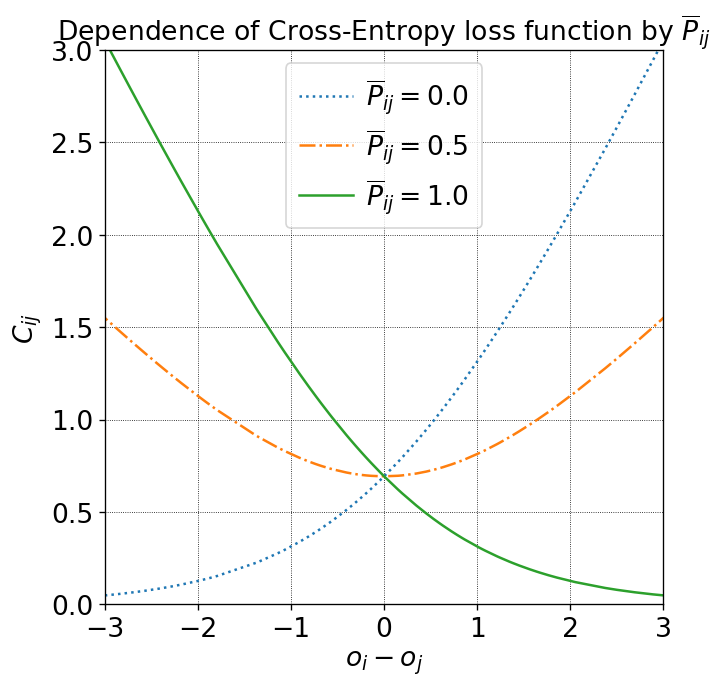

In [3]:
def c_ij(p_neg: float, o_ij: np.ndarray):
    """Calcualates cross-entropy loss function by
        C_{ij} = -\overline P_{ij} o_{ij} + \log(1 + e^{o_{ij}})

    Parameters
    ----------
    p_neg : float
        Negative probability of the fact, that i-th document more relevant than j-th document.
        Target of the model.
    o_ij : np.ndarray
        Difference between predicted relevances of x_i and x_j documents.

    Returns
    -------
    c : np.ndarray
    """
    return -p_neg * o_ij + np.log(1 + np.exp(o_ij))


def plot_cij_by_p_neg(p_neg: float, o_ij: np.ndarray):
    """Visualize dependence of cross-entropy loss function `C_ij` by `p_neg` value.
        C_{ij} = -\overline P_{ij} o_{ij} + \log(1 + e^{o_{ij}}).

    Parameters
    ----------
    p_neg : float
        Negative probability of the fact, that i-th document more relevant than j-th document.
        Target of the model.
    o_ij : np.ndarray
        Difference between predicted relevances of x_i and x_j documents.
    """
    loss = c_ij(p_neg, o_ij) 
    plt.plot(o_ij, loss, linestyle=linestyle, label='$\overline{P}_{ij}=%.1f$'%p_neg)
    plt.xlim([-3, 3]); plt.ylim([0, 3]);
    plt.xlabel('$o_i - o_j$'); plt.ylabel('$C_{ij}$');
    plt.title("Dependence of Cross-Entropy loss function by $\overline{P}_{ij}$");
    plt.legend(); plt.grid();

# Predicted relevances of x_i and x_j
o_i = 5*np.random.random(100)
o_j = 5*np.random.random(100)

o_ij = np.sort(o_i - o_j)
p_neg_values = [0.0, 0.5, 1.0]
linestyles = ['dotted', 'dashdot', '-']

# Plots the cross-entropy loss function by different p_neg values
plt.figure(figsize=(6, 6), dpi=120)
for p_neg, linestyle in zip(p_neg_values, linestyles):
    plot_cij_by_p_neg(p_neg, o_ij)


График значений функции ошибки  для всех рассмотренных случаев целевого значения (таргета)

Видно, что для бинарных оценок $0$ или $1$ функция симметрична с точностью до знака.

В случае одинаковой релевантности, т.е. когда таргет равен $0.5$, функция симметрична относительно $0$, и её оптимум находится в $0$. То есть, когда логиты для двух документов совпадают и их разность равна $0$, каждый из них равновероятно может быть выше другого.

### `RankNet`

In [4]:
class RankNet(torch.nn.Module):
    def __init__(self, num_input_features, hidden_dim=10):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.model = torch.nn.Sequential(
            torch.nn.Linear(num_input_features, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, 1),
        )
        
        self.out_activation = torch.nn.Sigmoid()

    def forward(self, input_1, input_2):
        logits_1 = self.predict(input_1)
        logits_2 = self.predict(input_2)
        
        logits_diff = logits_1 - logits_2
        out = self.out_activation(logits_diff)

        return out
    
    def predict(self, inp):
        logits = self.model(inp)
        return logits

## `Listwise`

В попарном подходе мы говорили о том, что расчёт функции потерь зависит от двух объектов.

Однако в `listwise`, как следует из названия, мы должны использовать функцию потерь, которая рассчитывается на всём множестве релевантных запросу документов.

> *Предположим, что мы использовали какую-то базовую предварительную модель, или кандидатную модель, для фильтрации мусора и получили всего три документа.*

Эти объекты подаются в алгоритм, который назван авторами подхода как __ListNet__, после чего мы получаем отранжированный список объектов, где на первом месте стоит самый релевантный документ.

Алгоритм производит некоторые скоры, по которым упорядочивается выдача. Эти скоры необходимо приводить к вероятностям релевантности документа запросу.

То есть, в отличие от попарного подхода, когда мы определяли вероятность того, что некоторый документ выше другого в выдаче или, другими словами, релевантнее, в данном случае мы возвращаемся к простой схеме оценки релевантности.

Набор вероятностей представляет собой распределение вероятностей, которое мы и хотим сделать похожим на наше истинное распределение. Истинное распределение мы будем пытаться получить из разметки.

*Здесь полагается, что разметка релевантности может быть любой* — *и бинарной, и многоуровневой*.

Существует некоторая неопределённость в предсказании отранжированных списков. То есть, как минимум, может быть шумная разметка, когда один разметчик решил, что релевантность документа нашему запросу равна тройке, а другой — что она равна четвёрке. На самом деле мы не знаем, как именно отранжировать список документов наилучшим образом.
> Поэтому делается предположение, что любая перестановка документов возможна, но при этом разные перестановки могут иметь разную вероятность, вычисленную на основе некоторой функции ранжирования.

Можем говорить, что _представлено полное множество перестановок $\Omega_n$, где $n$ - размер множества объектов, на которых рассчитываются перестановки.

Каждая перестановка $\pi$ характеризуется полным указанием, какой объект стоит на первой, на второй и т.д. до позиции $n$.

$ \pi = \left< \pi(1), \pi(2), ..., \pi(n) \right>$

Каждое $\pi_i$ указывает на номер конкретного объекта в перестановке. 

$$
    P_s(\pi) = \prod_{j=1}^{n} \frac {\phi(s_{\pi(j)}} {\sum_{k=j}^n \phi(s_{\pi(k)})}
$$

И в числителе, и в знаменателе к скору, или к логиту, $j$-го объекта конкретной перестановки $\pi_i$ применяется функция преобразования скоров.

К этой функции указываются следующие требования:

- Возрастающая;
- Строго положительная.

То есть, _чем больше логит, тем выше значение этой функции_, при этом ни при каких обстоятельствах _она не может стать отрицательной_ (*иначе бы мы могли получать отрицательные вероятности, чего быть не может*).

Под эти требования подходит много функций, но самая распространенная — _экспонента_, то есть возведение e в степень логита с индексом $\pi_j$.

Рассмотрим знаменатель: здесь сумма от $j$-го до $n$-го (последнего) объекта, суммируем мы в точности те же значения, что и в числителе — некоего рода нормализация.

Смотрим, какую долю от суммы всех скоров составляет наш текущий $j$-й объект.

Выводы для метода:

- Наибольшая вероятность у перестановки, в которой объекты отсортированы в порядке убывания.
- Наименьшая вероятность у перестановки, в которой объекты отсортированы в порядке возрастания.
- Количество перестановок равно $n!$ (много).

__TopOneProbability__ — вероятность того, что объект будет находиться на первом месте в отранжированном списке:

$$
    P_s(j) = \sum_{\pi(1) = j,\ \pi \in \Omega_n} P_s(\pi)
$$ 
— сумма вероятностей всех таких перестановок из множества $\Omega_n$, в которых первый и есть $j$-й объект.

Можно заметить, что для получения для всех n объектов этой вероятности (*TopOneProbability)* всё ещё необходимо считать все перестановки, т.е. никакого выигрыша мы не получаем.

С точки зрения математики эту вероятность можно найти куда более простым путем:

$$ 
    P_s(j) = \frac {\phi(s_j)} {\sum^n_{k = 1} \phi(s_k)}
$$ 
— вероятность того, что $j$-й объект будет первым в списке, равна отношению нашей экспоненциальной функции от предсказанного логита к сумме всех преобразованных логитов.

Такая операция называется SoftMax:

- Преобразует множество вещественных чисел в величины от $0$ до $1$.
- Сумма всех элементов множества будет равняться $1$ (суммарной вероятности всех событий).

Благодаря SoftMax не нужно считать все перестановки — можно получить скоры и преобразовать их в TopOneProbability.

Для обучения нашего алгоритма, для расчёта градиентов и градиентного спуска по весам, можно использовать любую функцию потерь, которая оптимизирует расстояние между двумя распределениями вероятностей.

Это может быть классическая _кросс-энтропия_:

$$
    L(y^{(i)}, z^{(i)}) = -\sum^n_{j = 1} P_{y^{(i)}}(j) \log(P_{z^{(i)}}(j))
$$
, где на вход передаются листы реальных меток $y$ для $i$-го запроса, а также предсказанные скоры $z$, и где мы суммируем по всем $n$ документам в выдаче.

Можно использовать что-то более специфичное, например _дивергенцию Кульбака-Лейблера_, которая является несимметричной мерой удалённости друг от друга двух вероятностных распределений:

$$
    D_{KL}(P || Q) = -\sum_{x \in X} P(x) \log(\frac {Q(x)} {P(x)})
$$

Эта мера равна $0$, когда два дискретных распределения полностью совпадают.

### `ListNet`

In [5]:
class ListNet(torch.nn.Module):
    def __init__(self, num_input_features: int, hidden_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        # укажите архитектуру простой модели здесь
        self.model = torch.nn.Sequential(
            torch.nn.Linear(num_input_features, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, 1)
        )

    def forward(self, input_1: torch.Tensor) -> torch.Tensor:
        logits = self.model(input_1)
        return logits

## Практика

Обучим модели `RankNet` и `ListNet` на данных [msrank_10k](https://catboost.ai/en/docs/concepts/python-reference_datasets_msrank_10k), предоставляемых библиотекой Catboost.

Реализуем класc _Trainer_, в который можно передавать нейронную сеть, её параметры и оцениваемую функцию метрики.  

Метрика `nDCG@k`

In [6]:
def ndcg_k(y_true: torch.Tensor, y_pred: torch.Tensor, top_k: int) -> float:

    def dcg(y_true: torch.Tensor, y_pred: torch.Tensor)-> float:
        # Sort ys
        _, argsort = torch.sort(y_pred, dim=0, descending=True)
        argsort = argsort[:top_k]
        y_true_sorted = y_true[argsort]
        # Metric value
        dcg = 0
        for i, l in enumerate(y_true_sorted, 1):
            dcg += (2 ** l - 1) / np.log2(i + 1)
        return float(dcg)

    empirical_dcg = dcg(y_true, y_pred)
    ideal_dcg = dcg(y_true, y_true)
    
    return empirical_dcg / ideal_dcg

Метрика `Average Precision`

In [7]:
def average_precision(ys_true: torch.Tensor, ys_pred: torch.Tensor) -> float:
    if ys_true.sum() == 0:
        return -1
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]
    rolling_sum = 0
    num_correct_ans = 0
    
    for idx, cur_y in enumerate(ys_true_sorted, start=1):
        if cur_y == 1:
            num_correct_ans += 1
            rolling_sum += num_correct_ans / idx
    if num_correct_ans == 0:
        return 0
    else:
        return rolling_sum / num_correct_ans

Метрика `Precision@k`

In [8]:
def precission_k(ys_true: torch.Tensor, ys_pred: torch.Tensor, top_k: int) -> float:
    """Metric:
        Calculates the precission at top-k predictions.

    Parameters
    ----------
    ys_true : `torch.Tensor`
        Correct labels rank.
    ys_pred : `torch.Tensor`
        Predicted labels rank.

    Returns
    -------
    p_at_k : `float`
    """
    if ys_true.sum() == 0:
        return -1
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]
    hits = ys_true_sorted[:top_k].sum()
    p_at_k = hits / min(ys_true.sum(), top_k)
    return float(p_at_k)

`Trainer` object

In [9]:
class Trainer:
    def __init__(self, model: torch.nn.Module,
                 metric_func: Callable[[torch.FloatTensor, torch.FloatTensor], float],
                 n_epochs: int = 5,
                 lr: float = 0.001,
                 model_params: Dict[Any, Any]=None,
                 metric_params: Dict[str, Any]=None):
        self._prepare_data()
        torch.manual_seed(0)

        self.n_epochs = n_epochs
        self.lr = lr

        self.metric_func = metric_func
        if 'metric_name' in metric_params:
            self.metric_name = deepcopy(metric_params['metric_name'])
            del metric_params['metric_name']
        else:
            self.metric_name = self.metric_func.__name__
        self.metric_params = metric_params

        # self.model = model(num_input_features=self.num_input_features,
                        #    **model_params)
        self.model = ListNet(num_input_features=self.num_input_features,
                             hidden_dim=10)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)


    def _get_data(self) -> List[np.ndarray]:
        train_df, test_df = msrank_10k()

        # [0, 1] column index = target/queryGroupID columns
        X_train = train_df.drop([0, 1], axis=1).values
        y_train = train_df[0].values
        query_ids_train = train_df[1].values.astype(int)

        X_test = test_df.drop([0, 1], axis=1).values
        y_test = test_df[0].values
        query_ids_test = test_df[1].values.astype(int)

        return [X_train, y_train, query_ids_train, 
                X_test, y_test, query_ids_test]


    def _scale_features_by_query_groups(self, 
                                        features: np.ndarray, 
                                        query_ids: np.ndarray) -> np.ndarray:
        for query_id in np.unique(query_ids):
            mask = query_id == query_ids
            scaler = StandardScaler()
            features[mask] = scaler.fit_transform(features[mask])
        return features


    def _prepare_data(self) -> None:
        (X_train, y_train, self.query_ids_train,
            X_test, y_test, self.query_ids_test) = self._get_data()
        self.query_ids_train_unique = np.unique(self.query_ids_train)
        self.query_ids_test_unique = np.unique(self.query_ids_test)

        X_train = self._scale_features_by_query_groups(X_train, self.query_ids_train)
        X_test = self._scale_features_by_query_groups(X_test, self.query_ids_train)
        
        self.X_train = torch.FloatTensor(X_train)
        self.X_test = torch.FloatTensor(X_test)
        self.y_train = torch.FloatTensor(y_train)
        self.y_test = torch.FloatTensor(y_test)
        # Model parameter
        self.num_input_features = self.X_train.shape[1]


    def _calculate_loss(self, batch_y_true: torch.FloatTensor, 
                        batch_y_pred: torch.FloatTensor) -> float:
        P_y_i = torch.softmax(batch_y_true, dim=0)
        P_z_i = torch.softmax(batch_y_pred, dim=0)
        return -torch.sum(P_y_i * torch.log(P_z_i / P_y_i))


    def _train_one_epoch(self) -> None:
        self.model.train()
        for query_id in self.query_ids_train_unique:
            mask = self.query_ids_train == query_id
            batch_X, batch_y = self.X_train[mask], self.y_train[mask]

            self.optimizer.zero_grad()

            batch_pred = self.model(batch_X).reshape(-1, )
            batch_loss = self._calculate_loss(batch_y, batch_pred)

            batch_loss.backward(retain_graph=True)
            self.optimizer.step()


    def _eval_test_set(self) -> None:
        with torch.no_grad():
            self.model.eval()
            metric = []
            for query_id in self.query_ids_test_unique:
                mask = self.query_ids_test == query_id
                pred = self.model(self.X_test[mask])
                metric_value = self.metric_func(self.y_test[mask], 
                                                pred, **self.metric_params)
                if type(metric_value) == np.nan:
                    metric.append(0)
                    continue
                else:
                    metric.append(metric_value)
            return np.mean(metric)


    def fit(self):
        scores = []
        print('Fit:')
        for epoch in range(self.n_epochs):
            self._train_one_epoch()
            eval_test_score = self._eval_test_set()
            scores.append(eval_test_score)
            if epoch % 5 == 0 or epoch == self.n_epochs - 1:
                print(f"\tepoch: {epoch+1}. {'-'*10}",
                      f"Avg {self.metric_name}: {eval_test_score:.4f}")
        return scores
    

    def save_model(self, 
                   path=f"./models/listnet__{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
    ) -> None:
        if not os.path.exists('models'):
            os.makedirs('models')
        f = open(path, 'wb')
        torch.save(self.model.state_dict, f)

    def load_model(self, path='./models/listnet__best.pth'):
        f = open(path, 'rb')
        state_dict = torch.load(f)
        self.model.load_state_dict(state_dict)

In [10]:
def plot_results(x: Iterable, y: Iterable,
                 model_name: str, 
                 model_params: Dict[str, Any],
                 metric_name: str) -> plt.Figure: 
    best_epoch = np.argmax(scores)
    best_score = scores[best_epoch]
    fig = plt.figure()
    # Best epoch
    plt.scatter(best_epoch+1, best_score,
                c='red',
                s=100,
                label=f"epoch={best_epoch}\n{metric_name}={best_score:.4f}")
    # Evaluation per epoch
    plt.plot(x, y,
             linestyle=':',
             marker='o',
             label=f"{model_name}:{model_params}")

    plt.title(f"${metric_name}$ evaluation per epoch")
    plt.xlabel("epoch"); plt.ylabel(f"{metric_name}");
    plt.legend();
    plt.grid();

    return fig    

Fit:
	epoch: 1. ---------- Avg nDCG@10: 0.3509
	epoch: 6. ---------- Avg nDCG@10: 0.3928
	epoch: 11. ---------- Avg nDCG@10: 0.4129
	epoch: 16. ---------- Avg nDCG@10: 0.4192
	epoch: 20. ---------- Avg nDCG@10: 0.4195
Fit:
	epoch: 1. ---------- Avg Precision@10: 0.9076
	epoch: 6. ---------- Avg Precision@10: 0.9500
	epoch: 11. ---------- Avg Precision@10: 0.9943
	epoch: 16. ---------- Avg Precision@10: 0.9852
	epoch: 20. ---------- Avg Precision@10: 0.9913


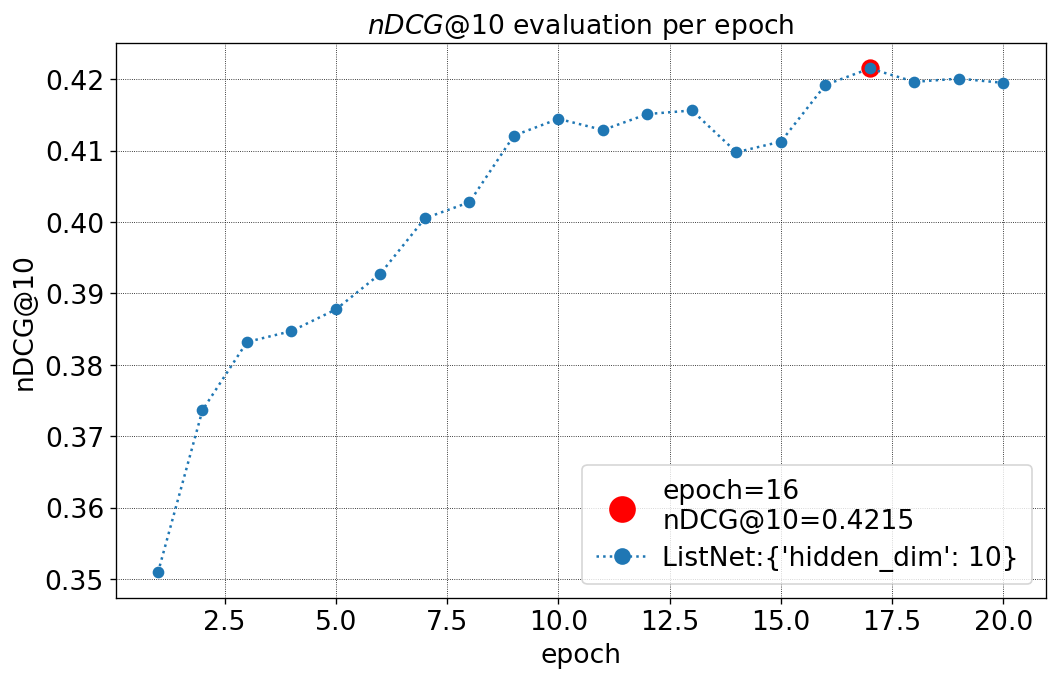

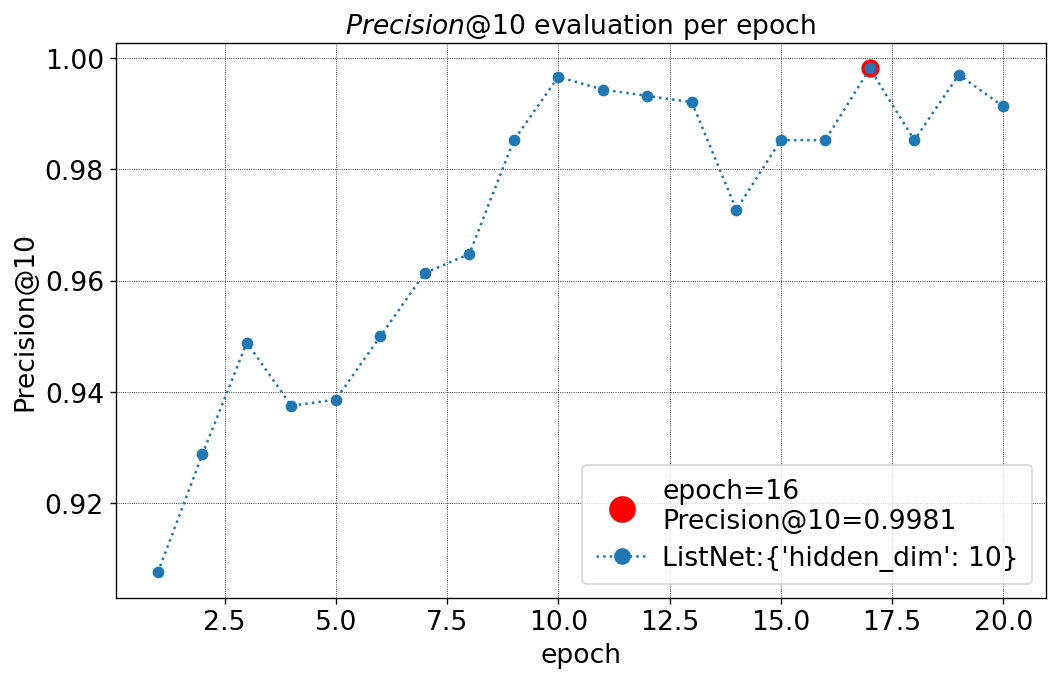

In [11]:
models = {
    "ListNet": (ListNet, {"hidden_dim": 10}),
}
top_k = 10
metrics = {
    f"nDCG@{top_k}": (ndcg_k, {"top_k": top_k, "metric_name": f"nDCG@{top_k}"}),
    f"Precision@{top_k}": (precission_k, {"top_k": top_k, "metric_name": f"Precision@{top_k}"}),
}

for metric_name, (metric_func, metric_params) in metrics.items():
    for model_name, (model, model_params) in models.items():
        estimator = Trainer(
            model=model,
            metric_func=metric_func,
            n_epochs=20,
            lr=0.001,
            model_params=model_params,
            metric_params=metric_params,
        )
        scores = estimator.fit()
        estimator.save_model()

        plot_results(range(1, estimator.n_epochs+1), 
                     scores, 
                     model_name, 
                     model_params,
                     metric_name)

___